In [1]:
%matplotlib inline
%load_ext line_profiler
from __future__ import print_function, division

from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, ReflectivityFitFunction, CurveFitter, to_parameters
import refnx.analysis.reflect as reflect

import corner
from lmfit.printfuncs import fit_report
import numpy as np
from matplotlib.pyplot import *

In [2]:
DATASET_NAME = 'c_PLP0011859_q.txt'
USE_DIFFERENTIAL_EVOLUTION = True

In [3]:
#load the data
dataset = ReflectDataset(DATASET_NAME)

xdata, ydata, dydata, dxdata = dataset.data

In [4]:
# These arrays described the layered nature of the system.
layers = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [30,  3.47, 0, 3],     # 1st layer
                   [250, 2.00, 0, 3],     # 2nd layer
                   [0,   6.36, 0, 3]])     # backing medium

lowlim = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [15,  3.47, 0, 1],     # 1st layer
                   [200, 0.10, 0, 1],     # 2nd layer
                   [0,   6.36, 0, 1]])     # backing medium

hilim = np.array([[0,   2.07, 0, 0],     # fronting medium
                  [50,  3.47, 0, 9],     # 1st layer
                  [300, 3.00, 0, 9],     # 2nd layer
                  [0,   6.36, 0, 9]])     # backing medium

In [5]:
# But we need these parameters in a 1D array. convert_layer_format_to_coefs does this.

coefs = reflect.convert_layer_format_to_coefs(layers, scale=1, bkg=3e-6)
lowlim = reflect.convert_layer_format_to_coefs(lowlim, scale=0.6, bkg=0)
hilim = reflect.convert_layer_format_to_coefs(hilim, scale=1.2, bkg=9e-6)

bounds = zip(lowlim, hilim)

In [6]:
# create a parameter instance
parameters = to_parameters(coefs, bounds=bounds, varies=[False] * 16)

# which parameters do you want to allow to vary
fitted_parameters = np.array([1, 6, 7, 8, 11, 12, 13, 15])
for fit in fitted_parameters:
    parameters['p%d' % fit].vary = True

In [7]:
# use resolution smearing and fit on a logR scale (transform the data as well)
t = Transform('logY').transform
ydata, dydata = t(xdata, ydata, dydata)
fcn_kws = {'transform': t, 'parallel': True, 'dqvals': dxdata}

In [8]:
# create the fit instance
RFF = ReflectivityFitFunction(transform=t)
fitter = CurveFitter(RFF,
                     xdata,
                     ydata,
                     parameters,
                     edata=dydata,
                     fcn_kws=fcn_kws)

#do the fit
method = 'leastsq'
if USE_DIFFERENTIAL_EVOLUTION:
    method='differential_evolution'

res = fitter.fit(method)

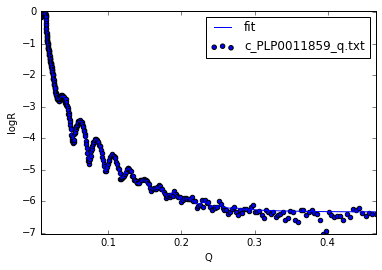

In [9]:
scatter(xdata, ydata, label=DATASET_NAME)
plot(xdata, RFF.model(xdata, res.params, dqvals=dxdata), label='fit')
ylim(min(np.min(ydata), np.min(fitter.model(res.params))),
     max(np.max(ydata), np.max(fitter.model(res.params))))
xlim(np.min(xdata), np.max(xdata))
xlabel('Q')
ylabel('logR')
legend()

c_PLP0011859_q.txt
[[Variables]]
    p0:    2 (fixed)
    p1:    0.87939760 (init= 1)
    p2:    2.07 (fixed)
    p3:    0 (fixed)
    p4:    6.36 (fixed)
    p5:    0 (fixed)
    p6:    4.5876e-07 (init= 3e-06)
    p7:    3.78792218 (init= 3)
    p8:    38.6402224 (init= 30)
    p9:    3.47 (fixed)
    p10:   0 (fixed)
    p11:   5.84407528 (init= 3)
    p12:   259.039819 (init= 250)
    p13:   2.40202005 (init= 2)
    p14:   0 (fixed)
    p15:   8.82378467 (init= 3)
[[Correlations]] (unreported correlations are <  0.100)


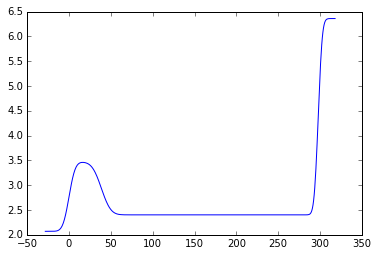

In [10]:
z, rho_z = RFF.sld_profile(res.params)
plot(z, rho_z)

print(DATASET_NAME)
print(fit_report(res.params))

In [11]:
res_emcee = fitter.emcee(res.params, steps=1000, burn=300, thin=10, workers=4)

In [12]:
print(fit_report(res_emcee))

[[Fit Statistics]]
    # function evals   = 0
    # data points      = unknown
    # variables        = 8
    chi-square         = unknown
    reduced chi-square = unknown
[[Variables]]
    p0:    2 (fixed)
    p1:    0.87998664 +/- 0.003012 (0.34%) (init= 0.8793976)
    p2:    2.07 (fixed)
    p3:    0 (fixed)
    p4:    6.36 (fixed)
    p5:    0 (fixed)
    p6:    4.5760e-07 +/- 2.20e-08 (4.80%) (init= 4.587556e-07)
    p7:    3.77563268 +/- 0.108777 (2.88%) (init= 3.787922)
    p8:    38.6903950 +/- 0.368025 (0.95%) (init= 38.64022)
    p9:    3.47 (fixed)
    p10:   0 (fixed)
    p11:   5.83441772 +/- 0.286906 (4.92%) (init= 5.844075)
    p12:   259.027974 +/- 0.243705 (0.09%) (init= 259.0398)
    p13:   2.40571429 +/- 0.011782 (0.49%) (init= 2.40202)
    p14:   0 (fixed)
    p15:   8.69137509 +/- 0.253833 (2.92%) (init= 8.823785)
[[Correlations]] (unreported correlations are <  0.100)
    C(p8, p12)                   = -0.910 
    C(p6, p7)                    =  0.634 
    C(p1, p

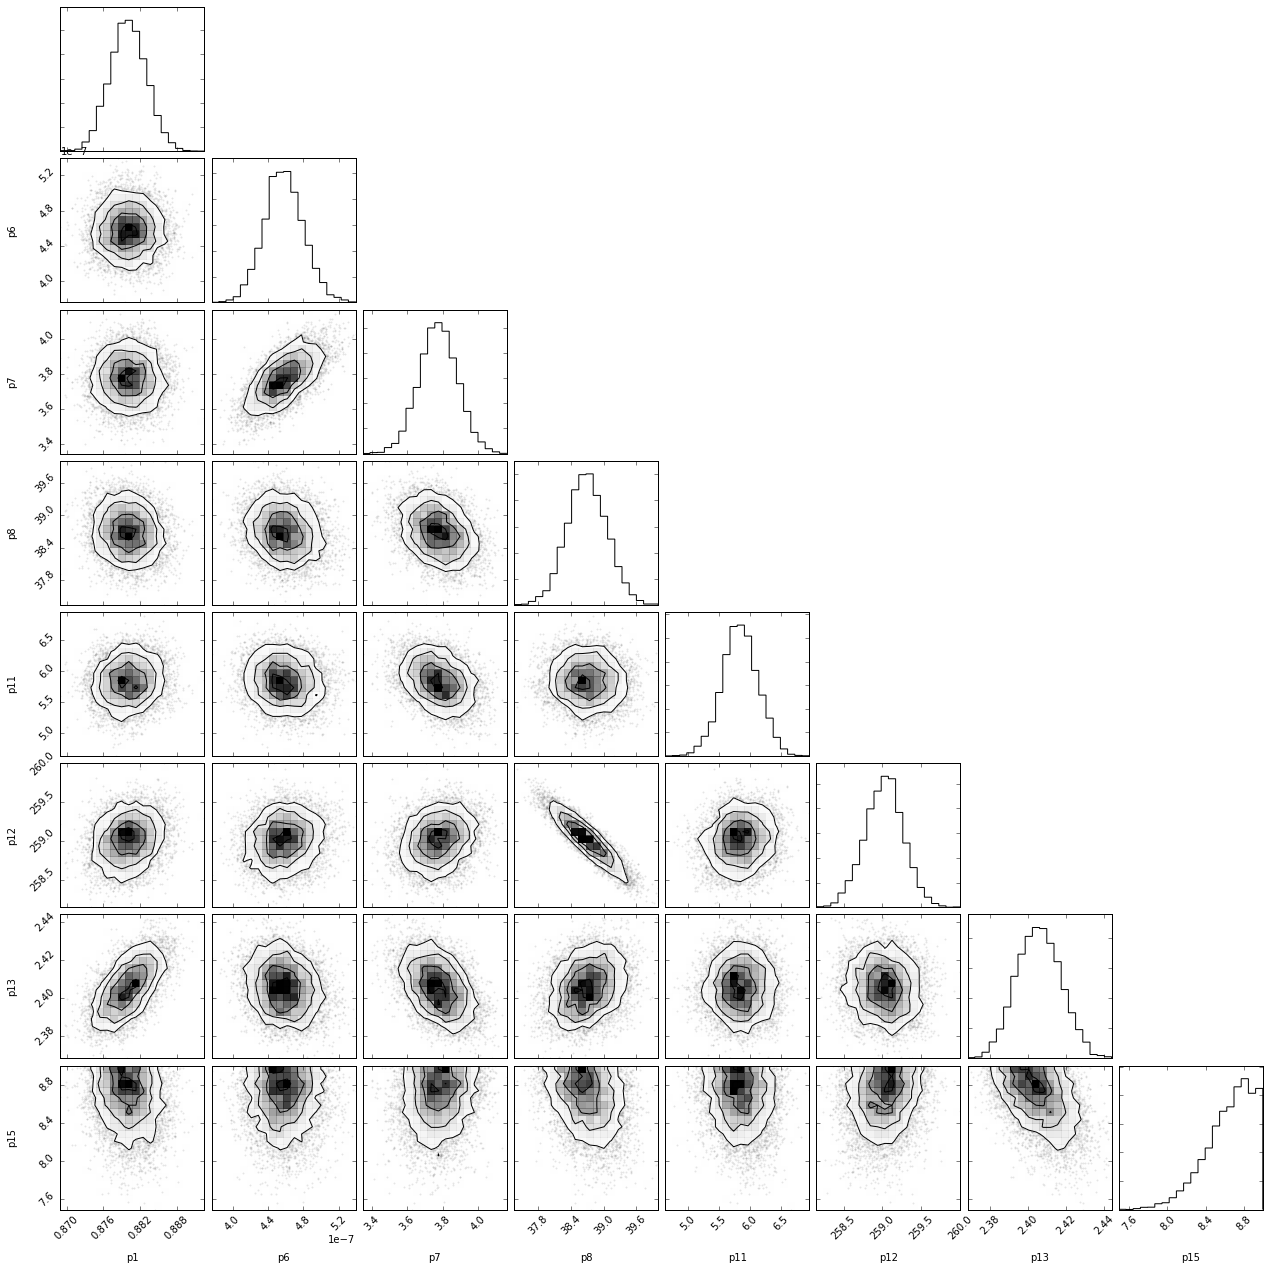

In [13]:
a = corner.corner(res_emcee.flatchain)

In [14]:
def pgen(parameters, flatchain, idx=None):
    # generator for all the different parameters from a flatchain.
    if idx is None:
        idx = range(np.size(flatchain, 0))
    for i in idx:
        vec = flatchain.iloc[i]
        for var_name in flatchain.columns:
            parameters[var_name].value = flatchain.iloc[i][var_name]
        yield parameters

(0.0080602199999999999, 0.465555)

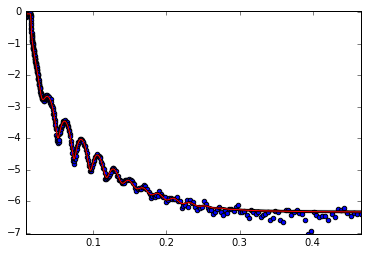

In [15]:
scatter(xdata, ydata)
for par in pgen(parameters, res_emcee.flatchain, idx=np.random.randint(len(res_emcee.flatchain), size=500)):
    plot(xdata, fitter.model(par), color="k", alpha=0.01)
plot(xdata, RFF.model(xdata, res_emcee.params), color='r')

ylim(np.min(ydata), np.max(ydata))
xlim(np.min(xdata), np.max(xdata))

(2.2, 6)

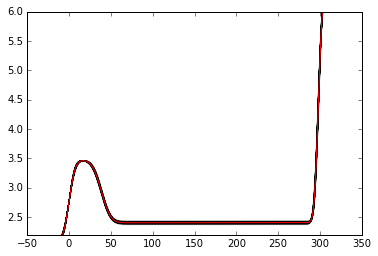

In [16]:
z, true_sld = RFF.sld_profile(res_emcee.params)
for par in pgen(parameters, res_emcee.flatchain, idx=np.random.randint(len(res_emcee.flatchain), size=500)):
    plot(z, RFF.sld_profile(par, points=z)[1], color='k', alpha =0.05)
    
plot(z, true_sld, lw=1, color='r')
ylim(2.2, 6)